In [1]:
'''data'''
import pandas as pd
import numpy as np
from datetime import datetime
import math


'''plotting'''
import matplotlib.pyplot as plt
from matplotlib import rc, font_manager
import seaborn as sns

'''sys library'''
#plt.style.use('fivethirtyeight')
import warnings
import os
import gc
warnings.filterwarnings('ignore')
%matplotlib inline
rc('font',family="NanumSquareR")

'''modeling'''
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
#from ggplot import *
from sklearn.linear_model import LinearRegression
import scipy.stats as st
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import uniform, randint
from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error
#-*- coding: utf-8 -*-

In [2]:
plt.style.use('ggplot') #ggplot스타일 사용
plt.rc('axes', unicode_minus=False)
rc('font', family='AppleGothic')

In [3]:
jeju_df = pd.read_csv('jeju_data_ver1/201901-202003.csv')

In [4]:
sub = pd.read_csv('jeju_data_ver1/submission.csv')

In [8]:
jeju_df.head()

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
0,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4
1,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,7,1374500,8
2,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,6,818700,6
3,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,4,1717000,5
4,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,3,1047300,3


# Data Cleansing

In [9]:
def data_wrangling(jeju_df):
    year_ls = []
    for i in jeju_df['REG_YYMM'].tolist():
        year_ls.append(int(str(i)[:4]))

    month_ls = []
    for i in jeju_df['REG_YYMM'].tolist():
        month_ls.append(int(str(i)[4:]))

    jeju_df['year'] = year_ls
    jeju_df['month'] = month_ls

    jeju_df.drop(columns = 'REG_YYMM',inplace = True)

    df = jeju_df.drop(columns = ['CARD_CCG_NM','HOM_CCG_NM'])

    columns = ['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year', 'month']
    df2 = df.groupby(columns).sum().reset_index(drop=False)

    # 인코딩
    dtypes = df2.dtypes
    encoders = {}
    for column in df2.columns:
        if str(dtypes[column]) == 'object':
            encoder = LabelEncoder()
            encoder.fit(df2[column])
            encoders[column] = encoder
    print(encoders)
    for column in encoders.keys():
        encoder = encoders[column]
        df2[column] = encoder.transform(df2[column])
        
    return encoders, df2

In [10]:
encoder_real, df2_real = data_wrangling(jeju_df)

{'CARD_SIDO_NM': LabelEncoder(), 'STD_CLSS_NM': LabelEncoder(), 'HOM_SIDO_NM': LabelEncoder(), 'AGE': LabelEncoder()}


In [11]:
df2_real

,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,year,month,CSTMR_CNT,AMT,CNT
0,0,0,0,1,1,1,2019,1,4,311200,4
1,0,0,0,1,1,1,2019,2,3,605000,3
2,0,0,0,1,1,1,2019,6,3,139000,3
3,0,0,0,1,1,1,2019,8,3,27500,3
4,0,0,0,1,1,1,2019,9,3,395500,3
...,...,...,...,...,...,...,...,...,...,...,...
1057389,16,40,16,6,2,5,2019,3,3,148000,4
1057390,16,40,16,6,2,5,2019,5,5,329800,7
1057391,16,40,16,6,2,5,2019,10,7,557800,7
1057392,16,40,16,6,2,5,2019,12,3,247800,3


## Default Modeling¶


In [12]:
# 4월의 데이터를 예측하는 데이터
# 랜덤으로 샘플링(개수 그대로) - frac : 비율
train_num = df2_real.sample(frac=1, random_state=0)
train_df = train_num.drop(columns = ['CSTMR_CNT','AMT','CNT'])

# loglp -> 로그화를 통해서 데이터의 분포를 수정(왜도가 오른쪽이 긴 꼬리 분포)
target = np.log1p(train_num['AMT'])

In [13]:
train_df.shape

(1057394, 8)

In [14]:

# train_df['covid'] = train_df.apply(lambda x: is_covid(x), axis=1)
# train_df['is_covid_plus'] = train_df.apply(lambda x: is_covid_plus(x), axis=1)

## prior month

In [17]:
# def is_covid(x):
#     if x['year'] == 2020:
#         if x['month'] ==3:
#             return 1
#         else:
#             return 0
#     else:
#         return 0

# def is_covid_plus(x):
#     # ['건강보조식품 소매업', '골프장 운영업','과실 및 채소 소매업', '그외 기타 종합 소매업', '기타 대형 종합 소매업', '기타음식료품위주종합소매업', '내항 여객 운송업', '빵 및 과자류 소매업', '수산물 소매업', '슈퍼마켓', '육류 소매업']
#     # [ 0,  1,  2,  6,  7, 11, 12, 17, 19, 20, 25])    
#     if x['STD_CLSS_NM'] in [ 0,  1,  2,  6,  7, 11, 12, 17, 19, 20, 25]:
#         return 1
#     else:
#         return 0   

def prior_month(x, pm = df2_real):
    try:
        y = x['year']
        m = x['month']
        ans=0
        if y == 2019:
            if m == 1:
                ans= pm[(df2_real['CARD_SIDO_NM']==x['CARD_SIDO_NM']) & 
                                (df2_real['STD_CLSS_NM']==x['STD_CLSS_NM']) &
                                (df2_real['HOM_SIDO_NM']==x['HOM_SIDO_NM']) &
                                (df2_real['AGE']==x['AGE'] )&
                                (df2_real['SEX_CTGO_CD']==x['SEX_CTGO_CD']) &
                                (df2_real['FLC']==x['FLC']) &
                                (df2_real['year']==2019) &
                                (df2_real['month']==12)
                               ].sample(1)['AMT'].values[0]
            else:
                ans= pm[(df2_real['CARD_SIDO_NM']==x['CARD_SIDO_NM']) & 
                                (df2_real['STD_CLSS_NM']==x['STD_CLSS_NM']) &
                                (df2_real['HOM_SIDO_NM']==x['HOM_SIDO_NM']) &
                                (df2_real['AGE']==x['AGE'] )&
                                (df2_real['SEX_CTGO_CD']==x['SEX_CTGO_CD']) &
                                (df2_real['FLC']==x['FLC']) &
                                (df2_real['year']==y) &
                                (df2_real['month']==m-1)
                               ].sample(1)['AMT'].values[0]
        elif y == 2020:
            if m == 1:
                ans= pm[(df2_real['CARD_SIDO_NM']==x['CARD_SIDO_NM']) & 
                                (df2_real['STD_CLSS_NM']==x['STD_CLSS_NM']) &
                                (df2_real['HOM_SIDO_NM']==x['HOM_SIDO_NM']) &
                                (df2_real['AGE']==x['AGE'] )&
                                (df2_real['SEX_CTGO_CD']==x['SEX_CTGO_CD']) &
                                (df2_real['FLC']==x['FLC']) &
                                (df2_real['year']==2019) &
                                (df2_real['month']==12)
                               ].sample(1)['AMT'].values[0]
            else:
                ans= pm[(df2_real['CARD_SIDO_NM']==x['CARD_SIDO_NM']) & 
                                (df2_real['STD_CLSS_NM']==x['STD_CLSS_NM']) &
                                (df2_real['HOM_SIDO_NM']==x['HOM_SIDO_NM']) &
                                (df2_real['AGE']==x['AGE'] )&
                                (df2_real['SEX_CTGO_CD']==x['SEX_CTGO_CD']) &
                                (df2_real['FLC']==x['FLC']) &
                                (df2_real['year']==y) &
                                (df2_real['month']==m-1)
                               ].sample(1)['AMT'].values[0]

        return ans
    except:
        return None

In [18]:
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()


In [19]:
train_df['prior_month'] = train_df.progress_apply(lambda x: prior_month(x), axis=1)

In [20]:
train_df

,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,year,month,prior_month
149245,2,4,2,2,1,2,2019,4,145000.0
554956,8,26,11,1,1,2,2020,2,NaN
918516,14,33,14,4,2,4,2019,5,744289264.0
425414,7,18,8,2,2,1,2019,10,4422765.0
640949,9,39,16,5,2,5,2020,1,805700.0
...,...,...,...,...,...,...,...,...,...
359783,6,16,9,1,1,1,2019,12,3498923.0
152315,2,7,11,3,2,3,2020,3,NaN
963395,15,19,9,5,1,5,2020,2,4325000.0
117952,1,31,4,1,1,2,2019,7,NaN


# lgbm

In [21]:
# 예측 템플릿 만들기
# 예측 템플릿을 실예측 탬플릿, 검증셋 탬플릿을 나눠서 구분
def predict_temp(df,train_df,real_train = True):
    if real_train == True:
        
        CARD_SIDO_NMs = df['CARD_SIDO_NM'].unique()
        STD_CLSS_NMs  = df['STD_CLSS_NM'].unique()
        HOM_SIDO_NMs  = df['HOM_SIDO_NM'].unique()
        AGEs          = df['AGE'].unique()
        SEX_CTGO_CDs  = df['SEX_CTGO_CD'].unique()
        FLCs          = df['FLC'].unique()
        years         = [2020]
        months        = [4,7]

        temp = []
        for CARD_SIDO_NM in CARD_SIDO_NMs:
            for STD_CLSS_NM in STD_CLSS_NMs:
                for HOM_SIDO_NM in HOM_SIDO_NMs:
                    for AGE in AGEs:
                        for SEX_CTGO_CD in SEX_CTGO_CDs:
                            for FLC in FLCs:
                                for year in years:
                                    for month in months:
                                        temp.append([CARD_SIDO_NM, STD_CLSS_NM, HOM_SIDO_NM, AGE, SEX_CTGO_CD, FLC, year, month])
                                        
        
                                        
        temp = np.array(temp)        
        temp_df = pd.DataFrame(data=temp, columns=['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year', 'month'])
        temp_df['prior_month'] = temp_df.apply(lambda x: prior_month(x))


        return temp_df

In [22]:
temp_real_lgb =predict_temp(df2_real,train_df,True)

In [23]:
temp_real_lgb['prior_month'] = temp_real_lgb.progress_apply(lambda x: prior_month(x), axis=1)

In [28]:
temp_real_lgb

,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,year,month,prior_month
0,0,0,0,1,1,1,2020,4,427510.0
1,0,0,0,1,1,1,2020,7,NaN
2,0,0,0,1,1,2,2020,4,NaN
3,0,0,0,1,1,2,2020,7,NaN
4,0,0,0,1,1,3,2020,4,NaN
...,...,...,...,...,...,...,...,...,...
1658855,16,30,14,0,2,3,2020,7,NaN
1658856,16,30,14,0,2,4,2020,4,NaN
1658857,16,30,14,0,2,4,2020,7,NaN
1658858,16,30,14,0,2,5,2020,4,NaN


In [29]:
# 학습 : 교차검증
# LGBM 예측 (실 예측 or 검증셋 예측)
def lgb_Regressor(train_df, temp, target):
    
    folds = KFold(n_splits=5,random_state = 1001)

    sub_predict = np.zeros(temp.shape[0])
    oof_predict = np.zeros(train_df.shape[0])
    feature_importance_df = pd.DataFrame()

    for folds_, (train_idx,valid_idx) in enumerate(folds.split(train_df,target)):
        train_x, train_y = train_df.iloc[train_idx], target.iloc[train_idx]
        valid_x, valid_y = train_df.iloc[valid_idx], target.iloc[valid_idx]
        
        '''
        params = {
            'learning_rate' : 0.05,
            'boosting_type': 'gbdt',
            'objective': 'tweedie',
            'tweedie_variance_power': 1.1,
            'metric': 'rmse',
            'sub_row' : 0.75,
            'lambda_l2' : 0.1
        }'''
        
        # 기존 파라미터 n_estimators = 5000, eval_metric = rmsle(평가 metric로 있는건가...) 이 상태 그대로
        # 학습량 5000까지 늘려서 검증해봐야겠다 근데 성능이 안좋을 것 같은게 처음에 완전 쌩 디폴트 파라미터로 제출한
        # lgbm모델의 성능이 더 좋았음
        reg = lgb.LGBMRegressor(random_state=0,n_estimators = 6000)

        reg.fit(train_x, train_y, eval_set = [(train_x, train_y), (valid_x, valid_y)],
               eval_metric='rmsle',verbose = 100)
        
        lgb.plot_metric(reg)
        plt.show()
        
        oof_predict[valid_idx] = reg.predict(valid_x,num_iteration = reg.best_iteration_)
        sub_predict += reg.predict(temp,num_iteration = reg.best_iteration_) / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = train_df.columns
        fold_importance_df["importance"] = reg.feature_importances_
        fold_importance_df["fold"] = folds_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
    feature_importance_fin = feature_importance_df[["feature", "importance"]].\
                groupby("feature").mean().sort_values(by="importance", ascending=False)
    
    
    return sub_predict, oof_predict, feature_importance_fin

In [30]:
# sub_lgb, oof_lgb,feature_importance_lgb = lgb_Regressor(train_df_remove3,
#                                                         temp_remove3_lgb,
#                                                         target_remove3)

[100]	training's l2: 0.492649	valid_1's l2: 0.491628
[200]	training's l2: 0.476298	valid_1's l2: 0.477411
[300]	training's l2: 0.46492	valid_1's l2: 0.468414
[400]	training's l2: 0.456359	valid_1's l2: 0.462139
[500]	training's l2: 0.449196	valid_1's l2: 0.456969
[600]	training's l2: 0.443311	valid_1's l2: 0.452962
[700]	training's l2: 0.438297	valid_1's l2: 0.449767
[800]	training's l2: 0.434336	valid_1's l2: 0.447469
[900]	training's l2: 0.430353	valid_1's l2: 0.445151
[1000]	training's l2: 0.426469	valid_1's l2: 0.442884
[1100]	training's l2: 0.422644	valid_1's l2: 0.440751
[1200]	training's l2: 0.419163	valid_1's l2: 0.438889
[1300]	training's l2: 0.416153	valid_1's l2: 0.437523
[1400]	training's l2: 0.413353	valid_1's l2: 0.436291
[1500]	training's l2: 0.410533	valid_1's l2: 0.434928
[1600]	training's l2: 0.407843	valid_1's l2: 0.433678
[1700]	training's l2: 0.405288	valid_1's l2: 0.432587
[1800]	training's l2: 0.402805	valid_1's l2: 0.43155
[1900]	training's l2: 0.400344	valid_1'

findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


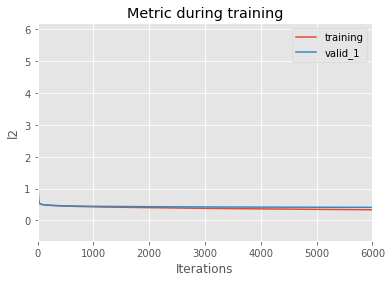

[100]	training's l2: 0.492102	valid_1's l2: 0.491804
[200]	training's l2: 0.4751	valid_1's l2: 0.476878
[300]	training's l2: 0.465135	valid_1's l2: 0.469035
[400]	training's l2: 0.456828	valid_1's l2: 0.462666
[500]	training's l2: 0.450345	valid_1's l2: 0.458029
[600]	training's l2: 0.44478	valid_1's l2: 0.454224
[700]	training's l2: 0.439212	valid_1's l2: 0.450289
[800]	training's l2: 0.434058	valid_1's l2: 0.446907
[900]	training's l2: 0.430163	valid_1's l2: 0.444648
[1000]	training's l2: 0.426355	valid_1's l2: 0.442489
[1100]	training's l2: 0.423194	valid_1's l2: 0.440969
[1200]	training's l2: 0.419827	valid_1's l2: 0.439038
[1300]	training's l2: 0.417064	valid_1's l2: 0.437813
[1400]	training's l2: 0.414126	valid_1's l2: 0.436335
[1500]	training's l2: 0.411705	valid_1's l2: 0.435389
[1600]	training's l2: 0.409067	valid_1's l2: 0.434133
[1700]	training's l2: 0.406562	valid_1's l2: 0.433107
[1800]	training's l2: 0.404208	valid_1's l2: 0.432072
[1900]	training's l2: 0.401791	valid_1's

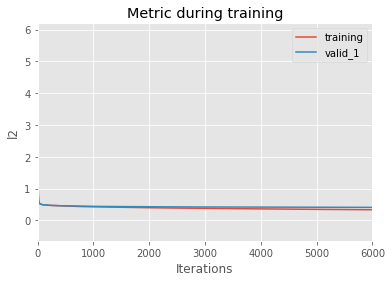

[100]	training's l2: 0.491771	valid_1's l2: 0.496619
[200]	training's l2: 0.474803	valid_1's l2: 0.481644
[300]	training's l2: 0.463852	valid_1's l2: 0.47276
[400]	training's l2: 0.455716	valid_1's l2: 0.466588
[500]	training's l2: 0.448699	valid_1's l2: 0.461465
[600]	training's l2: 0.442972	valid_1's l2: 0.45755
[700]	training's l2: 0.438311	valid_1's l2: 0.454427
[800]	training's l2: 0.433569	valid_1's l2: 0.451384
[900]	training's l2: 0.429459	valid_1's l2: 0.448707
[1000]	training's l2: 0.42608	valid_1's l2: 0.446932
[1100]	training's l2: 0.422484	valid_1's l2: 0.444775
[1200]	training's l2: 0.419022	valid_1's l2: 0.442753
[1300]	training's l2: 0.415964	valid_1's l2: 0.441184
[1400]	training's l2: 0.412915	valid_1's l2: 0.439607
[1500]	training's l2: 0.410305	valid_1's l2: 0.438385
[1600]	training's l2: 0.407823	valid_1's l2: 0.437389
[1700]	training's l2: 0.405324	valid_1's l2: 0.43623
[1800]	training's l2: 0.402767	valid_1's l2: 0.435022
[1900]	training's l2: 0.400334	valid_1's 

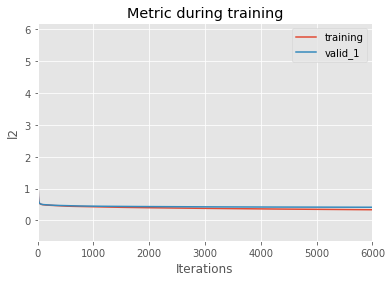

[100]	training's l2: 0.492517	valid_1's l2: 0.493491
[200]	training's l2: 0.474699	valid_1's l2: 0.477559
[300]	training's l2: 0.46399	valid_1's l2: 0.468667
[400]	training's l2: 0.456184	valid_1's l2: 0.462646
[500]	training's l2: 0.449855	valid_1's l2: 0.458125
[600]	training's l2: 0.44397	valid_1's l2: 0.454126
[700]	training's l2: 0.438468	valid_1's l2: 0.450287
[800]	training's l2: 0.433201	valid_1's l2: 0.446655
[900]	training's l2: 0.429125	valid_1's l2: 0.444297
[1000]	training's l2: 0.425611	valid_1's l2: 0.442382
[1100]	training's l2: 0.422166	valid_1's l2: 0.440621
[1200]	training's l2: 0.419216	valid_1's l2: 0.43921
[1300]	training's l2: 0.416217	valid_1's l2: 0.43782
[1400]	training's l2: 0.41331	valid_1's l2: 0.436463
[1500]	training's l2: 0.410505	valid_1's l2: 0.435182
[1600]	training's l2: 0.407645	valid_1's l2: 0.433648
[1700]	training's l2: 0.40512	valid_1's l2: 0.432638
[1800]	training's l2: 0.402587	valid_1's l2: 0.4315
[1900]	training's l2: 0.400374	valid_1's l2: 

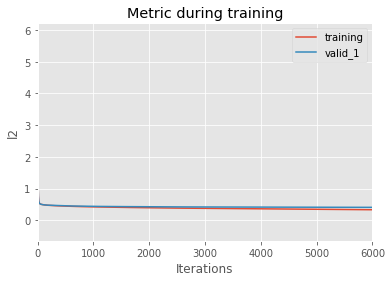

[100]	training's l2: 0.492046	valid_1's l2: 0.496461
[200]	training's l2: 0.474057	valid_1's l2: 0.480264
[300]	training's l2: 0.463543	valid_1's l2: 0.471678
[400]	training's l2: 0.455082	valid_1's l2: 0.46505
[500]	training's l2: 0.44832	valid_1's l2: 0.460242
[600]	training's l2: 0.442683	valid_1's l2: 0.456361
[700]	training's l2: 0.437675	valid_1's l2: 0.453086
[800]	training's l2: 0.433289	valid_1's l2: 0.450163
[900]	training's l2: 0.429547	valid_1's l2: 0.448043
[1000]	training's l2: 0.426013	valid_1's l2: 0.446244
[1100]	training's l2: 0.42238	valid_1's l2: 0.444255
[1200]	training's l2: 0.419366	valid_1's l2: 0.442785
[1300]	training's l2: 0.41626	valid_1's l2: 0.441181
[1400]	training's l2: 0.413269	valid_1's l2: 0.439714
[1500]	training's l2: 0.410238	valid_1's l2: 0.438279
[1600]	training's l2: 0.407474	valid_1's l2: 0.43697
[1700]	training's l2: 0.404827	valid_1's l2: 0.435721
[1800]	training's l2: 0.402226	valid_1's l2: 0.434478
[1900]	training's l2: 0.399916	valid_1's l

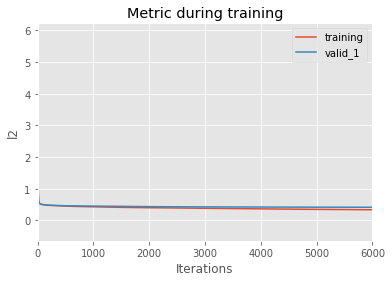

In [31]:
sub_lgb_real, oof_lgb_real,feature_importance_lgb_real = lgb_Regressor(train_df,
                                                        temp_real_lgb,
                                                        target)

## feature importance

findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


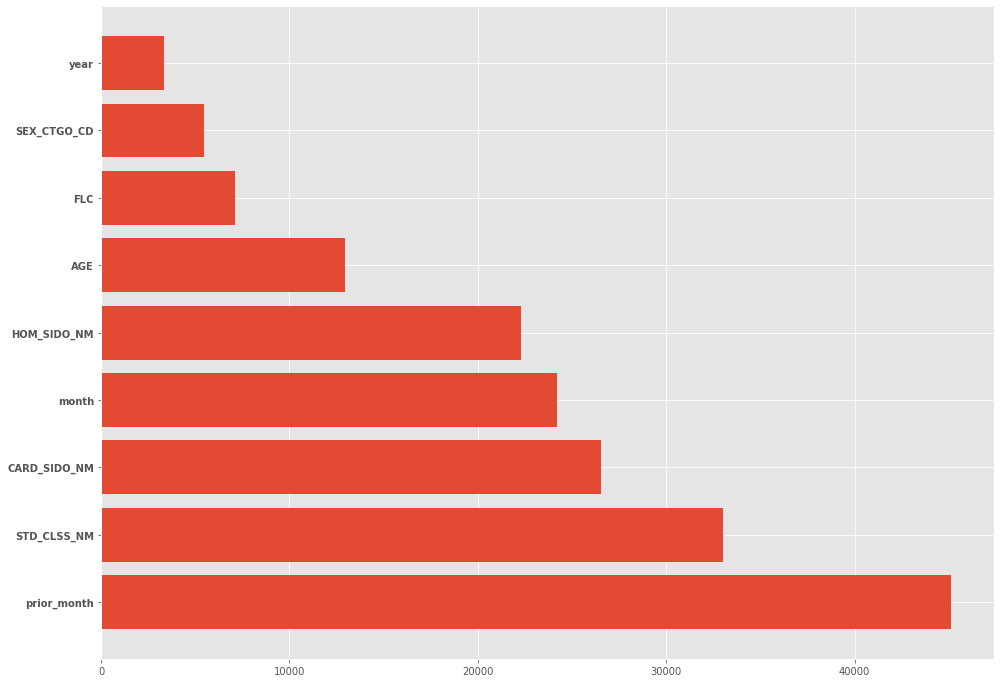

In [32]:
plt.figure(figsize = (16,12))
plt.barh(feature_importance_lgb_real.index,feature_importance_lgb_real['importance'])
plt.yticks(fontweight = 'bold')
plt.show()

## 제출 및 검증 코드

In [33]:
# 로컬에서 validation으로 검증할 것인지 or 실제 제출 파일을 만들 것인지?
def local_valid_function(sub,temp_df,sub_df,version_num,encoders,real_train = False):
    if real_train == False:
        pred = np.expm1(sub)
        temp_df['AMT'] = np.round(pred, 0)
        temp_df2 = temp_df
        temp_df['REG_YYMM'] = temp_df['year']*100 + temp_df['month']
        temp_df = temp_df[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
        temp_df = temp_df.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

        # 디코딩 
        temp_df['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp_df['CARD_SIDO_NM'])
        temp_df['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp_df['STD_CLSS_NM'])

        test_valid3 = sub_df.drop(['AMT'], axis=1)
        test_valid3 = test_valid3.merge(temp_remove3_lgb, left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], how='left')
        test_valid3.index.name = 'id'
        test_validation.drop(columns = 'id',inplace = True)
        sub.to_csv('제출폴더/submission_version1.csv', encoding='utf-8-sig')
        sub.head()
    
        return temp_df2 #test_valid3,
    
    elif real_train == True:
        
        pred = np.expm1(sub)
        temp_df['AMT'] = np.round(pred, 0)
        temp_df['REG_YYMM'] = temp_df['year']*100 + temp_df['month']
        temp_df = temp_df[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
        temp_df = temp_df.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

        # 디코딩 
        temp_df['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp_df['CARD_SIDO_NM'])
        temp_df['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp_df['STD_CLSS_NM'])

        sub = sub_df.drop(['AMT'], axis=1)
        sub = sub.merge(temp_df, left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], how='left')
        sub.index.name = 'id'
        try:
            sub.drop(columns = 'id',inplace = True)
        except:
            pass
        sub.to_csv('제출폴더/submission_version{}.csv'.format(version_num), encoding='utf-8-sig')
        #sub.head()
        
        return sub

In [34]:
sub = local_valid_function(sub_lgb_real,temp_real_lgb,sub,9,encoder_real,True)


In [1]:
temp_df2 = local_valid_function(sub_lgb,temp_remove3_lgb,test_validation3,6,encoder_real,False)

In [ ]:
RMSLE = np.sqrt(mean_squared_log_error(origin, test_valid3['AMT']))
